# Notebook for training a ML algorithm to predict attractants / repellents for _E. coli_

## PART 5: ML prediction

For this part, we will illustrate how to do a prediction using the ML model generated in PART 2 using a dataset of compounds associated to the Human COX1/COX2 target (csv file downloaded from ChEMBL database on the 29/02/2024)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ml_tools_path = r'../Python Scripts'   # Your path to ML_Tools.py
sys.path.append(ml_tools_path)
from ML_tools import name2smiles
from ML_tools import add_fingerprints
from ML_tools import add_descriptors

from rdkit.Chem import PandasTools

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

import pickle

In [3]:
# Variables
data_file = 'ChEMBL_COX1COX2_dataset.csv'
smiles_column='Smiles'
fp_type='RDkit'
nBits=512
scaling='MinMax'
drop_list=['BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO','BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW']
ml_method = 'RF_reg'
threshold=0.33
ml_file = f'../ML/chemotaxis_{ml_method}_model.pkl'

Load the dataset

In [4]:
dataset = pd.read_csv(data_file,sep=';')
dataset

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key
0,CHEMBL4758387,NaN,NaN,Unknown,NaN,433.51,3,7,3.38,110.11,...,29,8,2,0,433.0766,-1.47,NEUTRAL,C19H19N3O5S2,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,YXDZLKZATHLEFT-KEBDBYFISA-N
1,CHEMBL4754406,NaN,NaN,Unknown,NaN,373.46,3,13,3.37,91.65,...,25,6,2,0,373.0555,-1.80,NEUTRAL,C17H15N3O3S2,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3cccc(O)c3)n2)cc1,BJNKRYAVNXGRPH-VCHYOVAHSA-N
2,CHEMBL4790676,NaN,NaN,Unknown,NaN,417.51,3,12,3.68,89.88,...,28,7,1,0,417.0817,-1.79,NEUTRAL,C19H19N3O4S2,COc1cccc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)...,LRNPQDCEBNEWQR-RGVLZGJSSA-N
3,CHEMBL4781090,NaN,NaN,Unknown,NaN,447.54,3,7,3.69,99.11,...,30,8,1,0,447.0923,-1.55,NEUTRAL,C20H21N3O5S2,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,VJVBMTWGYKJGED-SRZZPIQSSA-N
4,CHEMBL4780636,NaN,NaN,Unknown,NaN,373.46,3,7,3.37,91.65,...,25,6,2,0,373.0555,-1.79,NEUTRAL,C17H15N3O3S2,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3ccc(O)cc3)n2)cc1,DQUUKYATKWSSMT-VCHYOVAHSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,CHEMBL94494,NaN,NaN,Small molecule,NaN,443.45,4,8,4.26,77.98,...,29,5,2,0,443.0385,-1.59,NEUTRAL,C18H13F4N3O2S2,Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...,DADHJCHABCTJSK-UHFFFAOYSA-N
176,CHEMBL118,CELECOXIB,CELECOXIB|Celebra|Celebrex|DFN-15|DFN15|ELYXYB...,Small molecule,4.0,381.38,310,3247,3.51,77.98,...,26,5,2,0,381.0759,-1.57,NEUTRAL,C17H14F3N3O2S,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,RZEKVGVHFLEQIL-UHFFFAOYSA-N
177,CHEMBL527,PIROXICAM,"BREXIDOL|CP-16,171|CP-16171|FELDENE 20|FELDENE...",Small molecule,4.0,331.35,231,1107,1.58,99.60,...,23,7,2,0,331.0627,-1.18,ACID,C15H13N3O4S,CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O,QYSPLQLAKJAUJT-UHFFFAOYSA-N
178,CHEMBL6,INDOMETHACIN,ACONIP|ARTRACIN|ARTRACIN SR|BERLIND 75 RET|DUR...,Small molecule,4.0,357.79,333,7267,3.93,68.53,...,25,5,1,0,357.0768,-0.72,ACID,C19H16ClNO4,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,CGIGDMFJXJATDK-UHFFFAOYSA-N


Extracting the smiles

In [5]:
smiles = dataset[smiles_column]
smiles

0      COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...
1        CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3cccc(O)c3)n2)cc1
2      COc1cccc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)...
3      COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...
4        CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3ccc(O)cc3)n2)cc1
                             ...                        
175    Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...
176    Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...
177            CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O
178       COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1
179          Cc1cnc(NC(=O)C2=C(O)c3ccccc3S(=O)(=O)N2C)s1
Name: Smiles, Length: 180, dtype: object

Get the RDKIT fingerprint for all compounds

,Smiles,RDKit_Mol
0,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,
1,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3cccc(O)c3)n2)cc1,
2,COc1cccc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)...,
3,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,
4,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3ccc(O)cc3)n2)cc1,
...,...,...
175,Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...,
176,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,
177,CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O,
178,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,

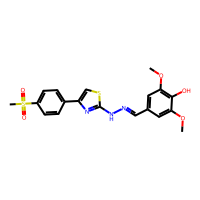
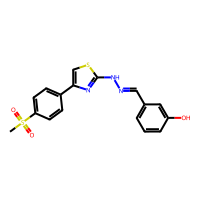
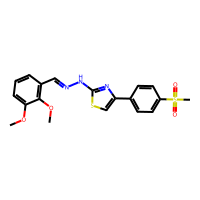
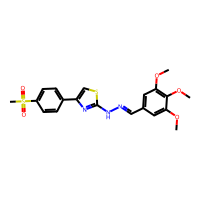
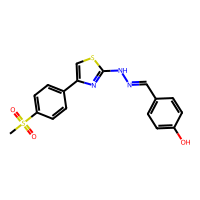
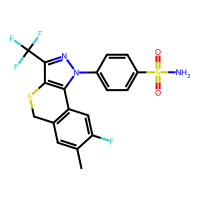
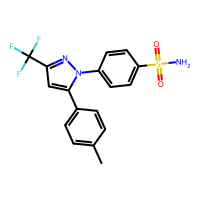
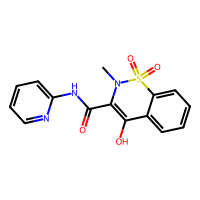
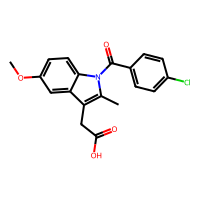
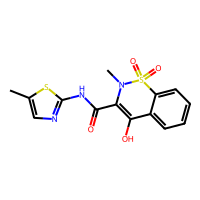

In [6]:
df = pd.DataFrame(smiles)
PandasTools.AddMoleculeColumnToFrame(df, smiles_column, 'RDKit_Mol')
df

Add 2D descriptors

In [7]:
df_descr = add_descriptors(df, column='RDKit_Mol', add2D=True, add3D=False)
df_descr

,Smiles,RDKit_Mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.550233,11.550233,0.077254,-3.230624,0.434044,11.551724,433.511,414.359,...,0,0,1,0,0,1,0,0,0,0
1,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3cccc(O)c3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.485950,11.485950,0.178727,-3.205115,0.528433,11.720000,373.459,358.339,...,0,0,1,0,0,1,0,0,0,0
2,COc1cccc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.549804,11.549804,0.279319,-3.214259,0.465914,11.535714,417.512,398.360,...,0,0,1,0,0,1,0,0,0,0
3,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.574316,11.574316,0.272941,-3.224607,0.415271,11.466667,447.538,426.370,...,0,0,1,0,0,1,0,0,0,0
4,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3ccc(O)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.485324,11.485324,0.205154,-3.202599,0.528433,11.720000,373.459,358.339,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,14.220403,14.220403,0.093726,-4.704745,0.600719,13.862069,443.447,430.343,...,1,1,0,0,0,0,0,0,0,0
176,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,13.125484,13.125484,0.137651,-4.605917,0.754105,12.346154,381.379,367.267,...,0,1,0,0,0,0,0,0,0,0
177,CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,12.501907,12.501907,0.046865,-3.905929,0.870184,15.956522,331.353,318.249,...,0,1,0,0,0,0,0,0,0,0
178,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,12.987203,12.987203,0.170239,-0.954711,0.767807,10.840000,357.793,341.665,...,0,0,0,0,0,0,0,0,0,0


As descriptors are used here, we need to get rid of the unused descriptors in the ML model

In [8]:
df_descr.drop(drop_list, axis=1, inplace=True)
df_descr

,Smiles,RDKit_Mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.550233,11.550233,0.077254,-3.230624,0.434044,11.551724,433.511,414.359,...,0,0,1,0,0,1,0,0,0,0
1,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3cccc(O)c3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.485950,11.485950,0.178727,-3.205115,0.528433,11.720000,373.459,358.339,...,0,0,1,0,0,1,0,0,0,0
2,COc1cccc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.549804,11.549804,0.279319,-3.214259,0.465914,11.535714,417.512,398.360,...,0,0,1,0,0,1,0,0,0,0
3,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.574316,11.574316,0.272941,-3.224607,0.415271,11.466667,447.538,426.370,...,0,0,1,0,0,1,0,0,0,0
4,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3ccc(O)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,11.485324,11.485324,0.205154,-3.202599,0.528433,11.720000,373.459,358.339,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,14.220403,14.220403,0.093726,-4.704745,0.600719,13.862069,443.447,430.343,...,1,1,0,0,0,0,0,0,0,0
176,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,13.125484,13.125484,0.137651,-4.605917,0.754105,12.346154,381.379,367.267,...,0,1,0,0,0,0,0,0,0,0
177,CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,12.501907,12.501907,0.046865,-3.905929,0.870184,15.956522,331.353,318.249,...,0,1,0,0,0,0,0,0,0,0
178,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,12.987203,12.987203,0.170239,-0.954711,0.767807,10.840000,357.793,341.665,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = df_descr.drop(['Smiles','RDKit_Mol'], axis=1)
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.550233,11.550233,0.077254,-3.230624,0.434044,11.551724,433.511,414.359,433.076613,152,...,0,0,1,0,0,1,0,0,0,0
1,11.485950,11.485950,0.178727,-3.205115,0.528433,11.720000,373.459,358.339,373.055483,128,...,0,0,1,0,0,1,0,0,0,0
2,11.549804,11.549804,0.279319,-3.214259,0.465914,11.535714,417.512,398.360,417.081698,146,...,0,0,1,0,0,1,0,0,0,0
3,11.574316,11.574316,0.272941,-3.224607,0.415271,11.466667,447.538,426.370,447.092263,158,...,0,0,1,0,0,1,0,0,0,0
4,11.485324,11.485324,0.205154,-3.202599,0.528433,11.720000,373.459,358.339,373.055483,128,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,14.220403,14.220403,0.093726,-4.704745,0.600719,13.862069,443.447,430.343,443.038532,152,...,1,1,0,0,0,0,0,0,0,0
176,13.125484,13.125484,0.137651,-4.605917,0.754105,12.346154,381.379,367.267,381.075882,136,...,0,1,0,0,0,0,0,0,0,0
177,12.501907,12.501907,0.046865,-3.905929,0.870184,15.956522,331.353,318.249,331.062677,118,...,0,1,0,0,0,0,0,0,0,0
178,12.987203,12.987203,0.170239,-0.954711,0.767807,10.840000,357.793,341.665,357.076786,128,...,0,0,0,0,0,0,0,0,0,0


Load the ML model and make a prediction

In [10]:
with open(ml_file, 'rb') as f:
    ml_model = pickle.load(f)

In [11]:
# Do a prediction
Y_pred = ml_model.predict(X)
Y_resp = np.asarray(['attractant' if y > threshold else 'repellent' if y < -1*threshold else 'none' for y in Y_pred])
Y_results=pd.concat([df,pd.DataFrame({'Y_pred': Y_pred, 'Pred_response': Y_resp})],axis=1)
Y_results

,Smiles,RDKit_Mol,Y_pred,Pred_response
0,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,-0.24,none
1,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3cccc(O)c3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,-0.08,none
2,COc1cccc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,-0.04,none
3,COc1cc(/C=N/Nc2nc(-c3ccc(S(C)(=O)=O)cc3)cs2)cc...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,-0.08,none
4,CS(=O)(=O)c1ccc(-c2csc(N/N=C/c3ccc(O)cc3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8C...,-0.04,none
...,...,...,...,...
175,Cc1cc2c(cc1F)-c1c(c(C(F)(F)F)nn1-c1ccc(S(N)(=O...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,0.00,none
176,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2...,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,0.08,none
177,CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,0.04,none
178,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000231E8D...,-0.04,none


Plot the results

C:\Users\kgr26424\AppData\Local\Temp\ipykernel_20204\3846556989.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=Y_results, x='Pred_response',palette=palette)


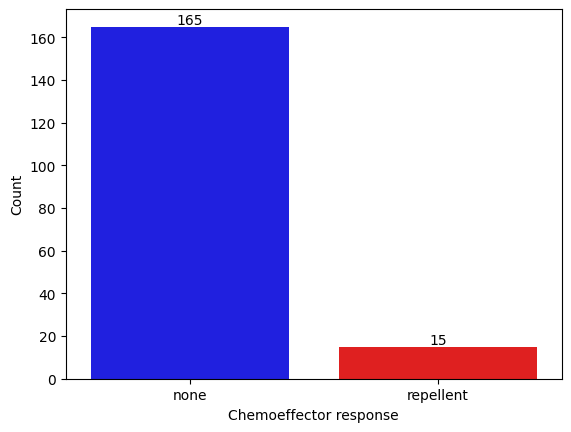

In [12]:
palette = []
for pred in pd.Series(Y_resp).unique():
    if pred == 'attractant':
        palette.append('green')
    elif pred == 'repellent':
        palette.append('red')
    else:
        palette.append('blue')
fig, ax = plt.subplots()
ax = sns.countplot(data=Y_results, x='Pred_response',palette=palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel('Chemoeffector response')
ax.set_ylabel('Count')
plt.show()

Check the attractant

In [13]:
attractant = Y_results[Y_results['Pred_response']=='attractant'].copy()
attractant.drop(['RDKit_Mol'], axis=1, inplace=True)
PandasTools.AddMoleculeColumnToFrame(attractant, smiles_column, 'RDKit_Mol')
attractant.sort_values(by='Y_pred', ascending=False)
attractant

,Smiles,Y_pred,Pred_response,RDKit_Mol


Check the repellent.

,Smiles,Y_pred,Pred_response,RDKit_Mol
9,Cc1onc(-c2ccc(Cl)o2)c1-c1ccccc1F,-0.44,repellent,
10,O=C(O)C1=Cc2cc(Cl)ccc2OC1C(F)(F)F,-0.36,repellent,
16,Cc1onc(-c2ccc(Br)o2)c1-c1ccccc1,-0.40,repellent,
19,Cc1onc(-c2ccc(Cl)o2)c1-c1ccc(F)cc1,-0.40,repellent,
29,Cc1onc(-c2cccc(Cl)c2)c1-c1ccccc1,-0.36,repellent,
30,Cc1ccc(-c2noc(C)c2-c2ccccc2)o1,-0.48,repellent,
39,Cc1ccnc(C(=O)c2[nH]c3ccc(F)cc3c2CC(=O)O)c1,-0.40,repellent,
91,CC(=O)/C(=C(\N)c1ccco1)c1ccccc1,-0.40,repellent,
101,Cc1onc(-c2ccco2)c1-c1ccccc1,-0.48,repellent,
112,Cc1onc(-c2ccccc2Cl)c1-c1ccccc1,-0.36,repellent,

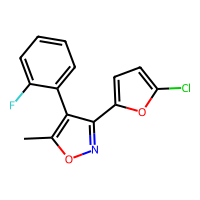
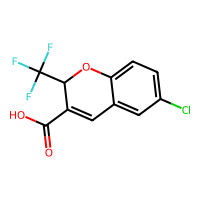
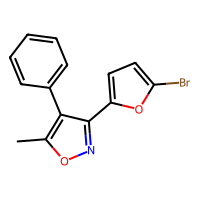
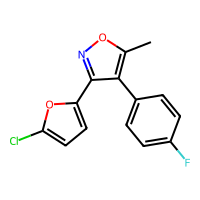
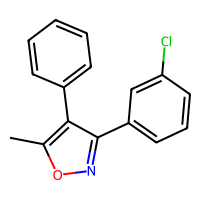
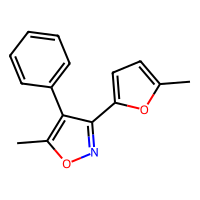
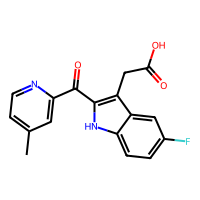
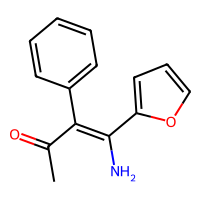
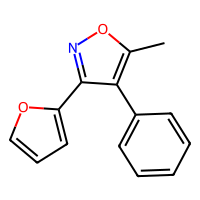
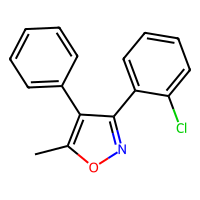
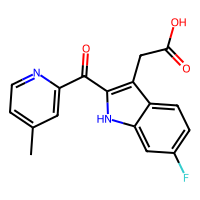
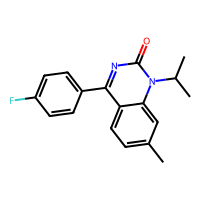
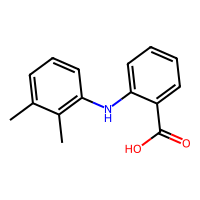
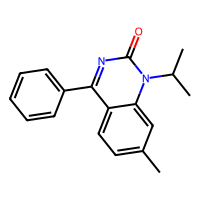
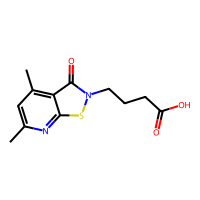

In [14]:
repellent = Y_results[Y_results['Pred_response']=='repellent'].copy()
repellent.drop(['RDKit_Mol'], axis=1, inplace=True)
PandasTools.AddMoleculeColumnToFrame(repellent, smiles_column, 'RDKit_Mol')
repellent.sort_values(by='Y_pred', ascending=True)
repellent